## INTRODUCTION


---


**WHAT YOU WILL SEE IN THIS KERNEL :**

*   **Neural Networks:** Keras & Tensorflow based model to predict the success of the marketting campaign. 

*   **Multi model evaluation:** Gradient Boosted Trees, XGBosst, Light GBM, Logistic Regression, Support Vector Machines, Naive Bayes (Gaussian NB), KNN, Neural Networks

*   **SMOTE** to handle imbalanced data

*   **Kappa** score to evaluate models for imbalanced data. Accuracy is ususally not a good measure for imbalanced datasets. Cohen’s kappa statistic is a very good measure that can handle very well both multi-class and imbalanced class problems. It basically tells you how much better your classifier is performing over the performance of a classifier that simply guesses at random according to the frequency of each class.

*   **ROC_AUC Curves and PR AUC Curves** for model evaluation

*   **Additional Insights** in Exploratory Data Analysis

---
**DATASET:**


The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.
 
---
**IMBALANCED DATA:** Since the data is imbalanced, appropriate steps have to be taken to analyze and predict skewed classes. 

Steps taken to handle imbalanced data - 
*   Accuracy is avoided as the model performance metric. Precision, Recall, F1 Score, Kappa , ROC-AUC & PR AUC have been considered to evaluate models.
*   Generate Synthetic Samples using SMOTE for the minority class.
*   Different algorithm were evaluated, and the one with best performance was selected.

---

Lets begin! The Basics first!


Load all the necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTENC
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
#from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.ticker import FormatStrFormatter

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

Load the data from csv and verify the structure and counts from the dataframe

In [4]:
df_eda = pd.read_csv('../../Data/bank-additional-full.csv',sep=';') 

df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Lets begin with some basic cleanup. 

Check how many NULLs are present in the dataset

In [5]:
df_eda.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Check for duplicates in the dataset

In [6]:
len(df_eda)-len(df_eda.drop_duplicates())

12

Drop the duplicates in the dataset

In [7]:
df_eda = df_eda.drop_duplicates()

## EXPLORATORY DATA ANALYSIS

Data has been analyzed for - 

*   Correlations
*   Univariate & Bivariate analysis
*   Outliers

*Age*: Check how customers' behavior is per age group

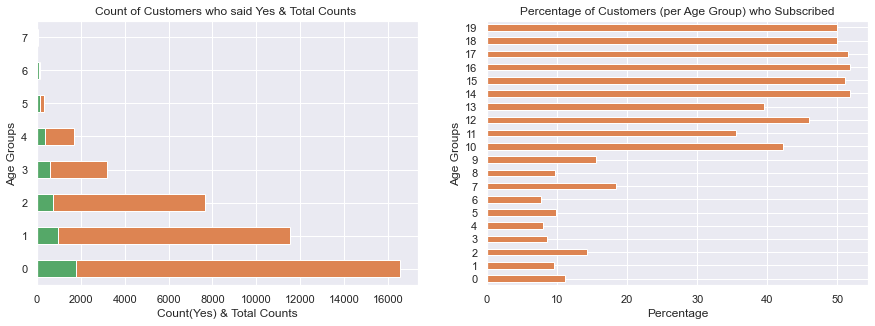

In [8]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["age"].value_counts(bins=8).plot(kind='barh', color="C1", ax=axs[0])
df_eda[df_eda["y"]=='yes']["age"].value_counts(bins=8).plot(kind='barh', ax = ax, color="C2")
ax2 = (df_eda[df_eda["y"]=='yes']["age"].value_counts(bins=20) * 100 / df_eda["age"].value_counts(bins=20) ).plot(kind='barh', color="C1", ax=axs[1])
axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Age Groups')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Age Groups')
axs[1].title.set_text('Percentage of Customers (per Age Group) who Subscribed')

*Conclusion:*

*   Any customer above the age of 60 has atleast a 40% chance of subscribing for the Bank Term Deposit.
*   Customers above the age of 73 have a 50% chance of saying YES.

Age has some outliers

<AxesSubplot:xlabel='age'>

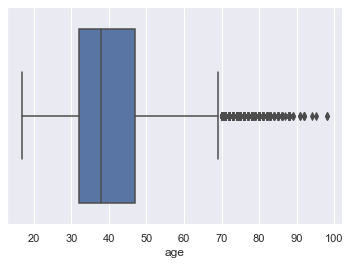

In [9]:
sns.boxplot(x=df_eda['age'])

Next,

Lets evaluate the *Job* categories for the different clients

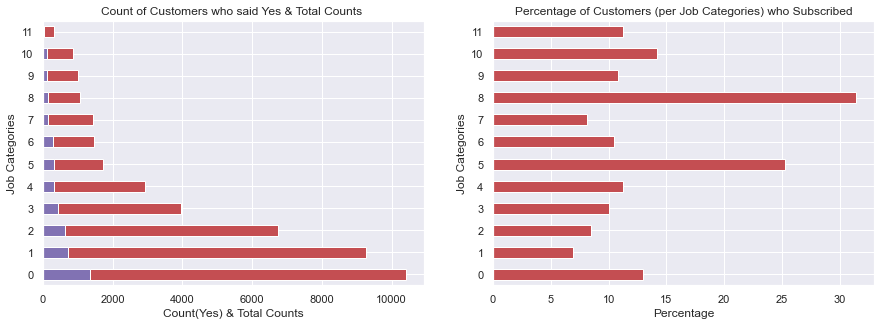

In [10]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)
ax = df_eda["job"].value_counts().plot(kind='barh', color="C3", ax=axs[0])
df_eda[df_eda["y"]=='yes']["job"].value_counts().plot(kind='barh', ax = ax, color="C4")
ax = (df_eda[df_eda["y"]=='yes']["job"].value_counts() * 100 / df_eda["job"].value_counts() ).plot(kind='barh', color="C3", ax=axs[1])
axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Job Categories')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Job Categories')
axs[1].title.set_text('Percentage of Customers (per Job Categories) who Subscribed')

*Conclusion:*

*   Students and Retired customers have a good chance(> 25%) of creating a Fixed Deposit. 



Next,

Lets explore the *Marital* status of customers.

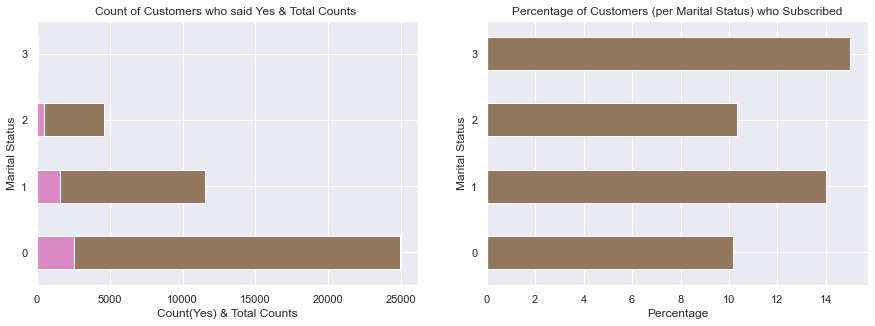

In [11]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["marital"].value_counts().plot(kind='barh', color="C5", ax=axs[0])
df_eda[df_eda["y"]=='yes']["marital"].value_counts().plot(kind='barh', ax = ax, color="C6")
ax = (df_eda[df_eda["y"]=='yes']["marital"].value_counts() * 100 / df_eda["marital"].value_counts() ).plot(kind='barh', color="C5", ax=axs[1])

axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Marital Status')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Marital Status')
axs[1].title.set_text('Percentage of Customers (per Marital Status) who Subscribed')

There isn't much of a trend here. Lets move on. 

Lets explore the *Education* of the customers.

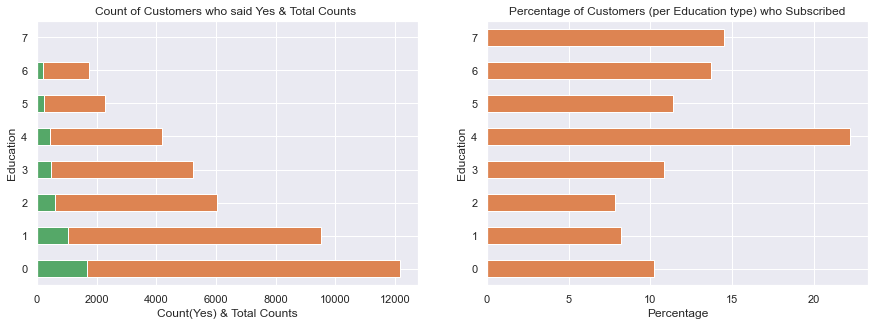

In [12]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["education"].value_counts().plot(kind='barh', color="C1", ax=axs[0])
df_eda[df_eda["y"]=='yes']["education"].value_counts().plot(kind='barh', ax = ax, color="C2")
ax = (df_eda[df_eda["y"]=='yes']["education"].value_counts() * 100 / df_eda["education"].value_counts() ).plot(kind='barh', color="C1", ax=axs[1])

axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Education')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Education')
axs[1].title.set_text('Percentage of Customers (per Education type) who Subscribed')

*Conclusion:*

*   Surprisingly, the Illiterate category has a higher chance(> 20%) of opting for the Term Deposit.

Next, lets check the numbers on whether the has customer *Defaulted* before or not.

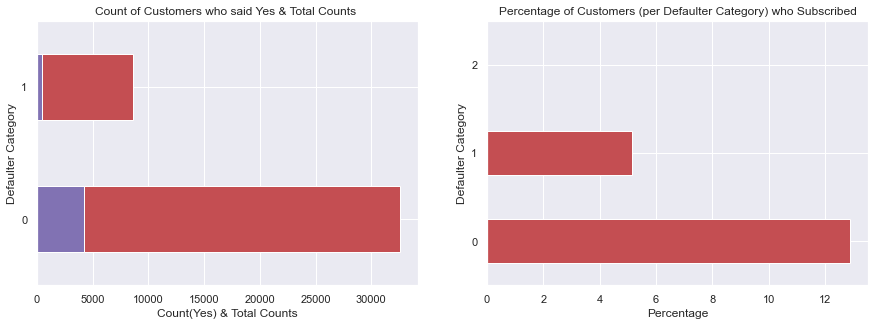

In [13]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["default"].value_counts().plot(kind='barh', color="C3", ax=axs[0])
df_eda[df_eda["y"]=='yes']["default"].value_counts().plot(kind='barh', ax = ax, color="C4")
ax = (df_eda[df_eda["y"]=='yes']["default"].value_counts() * 100 / df_eda["default"].value_counts() ).plot(kind='barh', color="C3", ax=axs[1])

axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Defaulter Category')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Defaulter Category')
axs[1].title.set_text('Percentage of Customers (per Defaulter Category) who Subscribed')

As expected, customers who have not defaulted have a higher probability of taking the Term Deposit. 

Lets check further,

*Housing* Loan is the next attribute.

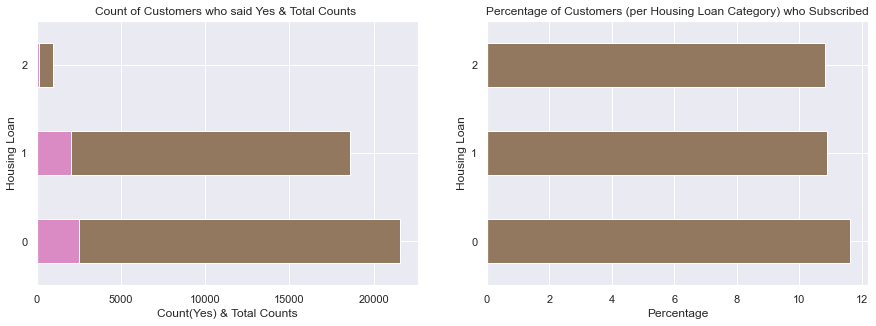

In [14]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["housing"].value_counts().plot(kind='barh', color="C5", ax=axs[0])
df_eda[df_eda["y"]=='yes']["housing"].value_counts().plot(kind='barh', ax = ax, color="C6")
ax = (df_eda[df_eda["y"]=='yes']["housing"].value_counts() * 100 / df_eda["housing"].value_counts() ).plot(kind='barh', color="C5", ax=axs[1])

axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Housing Loan')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Housing Loan')
axs[1].title.set_text('Percentage of Customers (per Housing Loan Category) who Subscribed')

Again, no trend noticed here. 

Next is Personal *Loan*

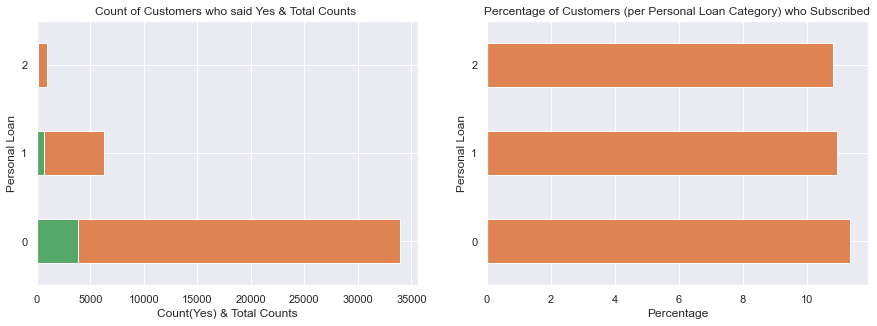

In [15]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["loan"].value_counts().plot(kind='barh', color="C1", ax=axs[0])
df_eda[df_eda["y"]=='yes']["loan"].value_counts().plot(kind='barh', ax = ax, color="C2")
ax = (df_eda[df_eda["y"]=='yes']["loan"].value_counts() * 100 / df_eda["loan"].value_counts() ).plot(kind='barh', color="C1", ax=axs[1])

axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Personal Loan')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Personal Loan')
axs[1].title.set_text('Percentage of Customers (per Personal Loan Category) who Subscribed')

Nothing here. 

Lets evaluate *Contact* communication type

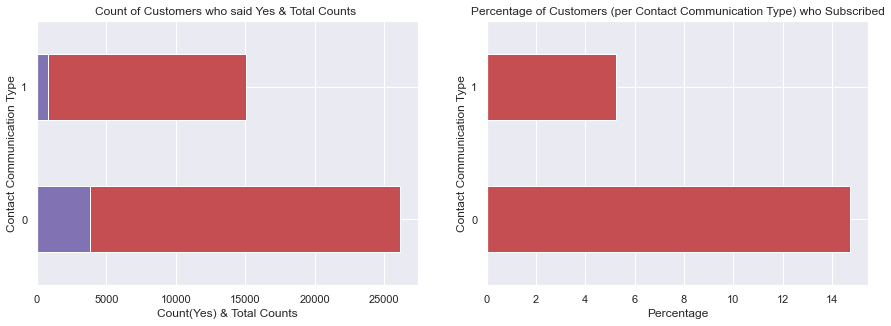

In [16]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["contact"].value_counts().plot(kind='barh', color="C3", ax=axs[0])
df_eda[df_eda["y"]=='yes']["contact"].value_counts().plot(kind='barh', ax = ax, color="C4")
ax = (df_eda[df_eda["y"]=='yes']["contact"].value_counts() * 100 / df_eda["contact"].value_counts() ).plot(kind='barh', color="C3", ax=axs[1])

axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Contact Communication Type')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Contact Communication Type')
axs[1].title.set_text('Percentage of Customers (per Contact Communication Type) who Subscribed')

People with a Mobile phone have a higher probability of accepting the offer from the bank.

Time usually plays an important role with how decisions are made. Lets see how it plays out with this dataset.

Lets evaluate the *Month* when the last contact was made.

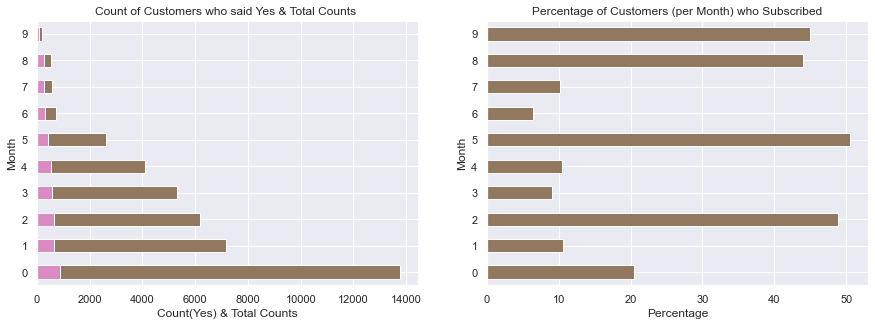

In [17]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["month"].value_counts().plot(kind='barh', color="C5", ax=axs[0])
df_eda[df_eda["y"]=='yes']["month"].value_counts().plot(kind='barh', ax = ax, color="C6")
ax = (df_eda[df_eda["y"]=='yes']["month"].value_counts() * 100 / df_eda["month"].value_counts() ).plot(kind='barh', color="C5", ax=axs[1])

axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Month')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Month')
axs[1].title.set_text('Percentage of Customers (per Month) who Subscribed')

*Conclusion:*

*   Mar, Sep, Dec & Oct where great months for the campaign with a 40% or more probability of customers accepting the marketting offer. It generally seems like the last month of each quarter is a fruitful time for campaigning.

Next is *Day of the Week*

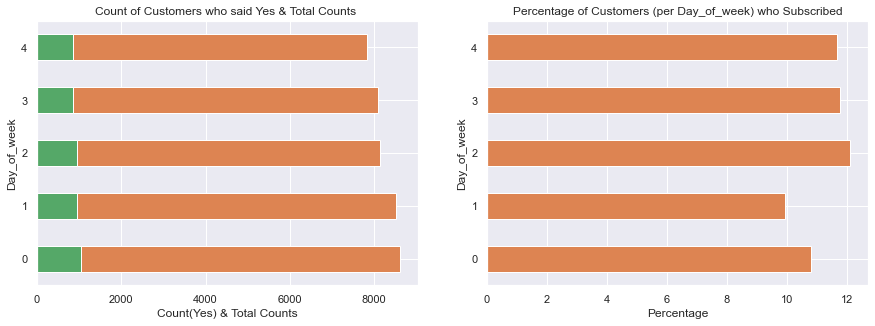

In [18]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["day_of_week"].value_counts().plot(kind='barh', color="C1", ax=axs[0])
df_eda[df_eda["y"]=='yes']["day_of_week"].value_counts().plot(kind='barh', ax = ax, color="C2")
ax = (df_eda[df_eda["y"]=='yes']["day_of_week"].value_counts() * 100 / df_eda["day_of_week"].value_counts() ).plot(kind='barh', color="C1", ax=axs[1])

axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Day_of_week')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Day_of_week')
axs[1].title.set_text('Percentage of Customers (per Day_of_week) who Subscribed')

No trend noticed here. 

Lets plot *Duration* too

<AxesSubplot:>

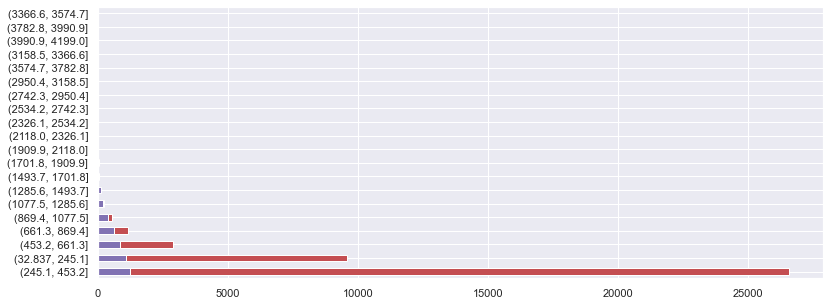

In [19]:
ax = df_eda["duration"].value_counts(bins=20).plot(kind='barh', color="C3", figsize=(13,5))
df_eda[df_eda["y"]=='yes']["duration"].value_counts(bins=20).plot(kind='barh', ax = ax, color="C4")

Duration has outliers. Few people had long conversations!

<AxesSubplot:xlabel='duration'>

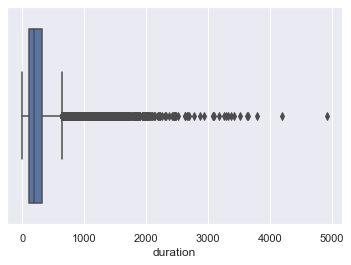

In [20]:
sns.boxplot(x=df_eda['duration'])

Campaign styles play an important role in converting a sale or not.

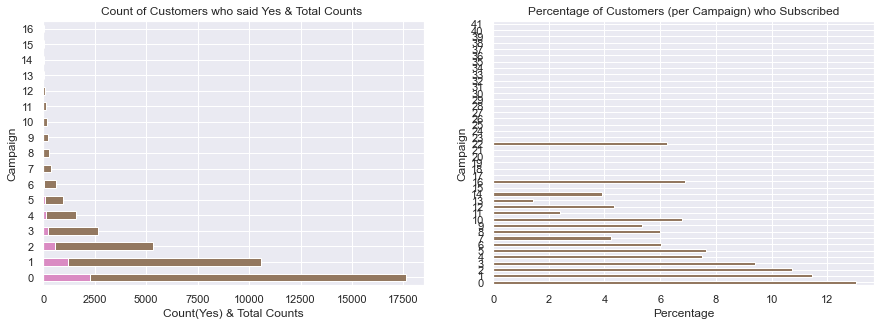

In [21]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["campaign"].value_counts().plot(kind='barh', color="C5", ax=axs[0])
df_eda[df_eda["y"]=='yes']["campaign"].value_counts().plot(kind='barh', ax = ax, color="C6")
ax = (df_eda[df_eda["y"]=='yes']["campaign"].value_counts() * 100 / df_eda["campaign"].value_counts() ).plot(kind='barh', color="C5", ax=axs[1])

axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Campaign')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Campaign')
axs[1].title.set_text('Percentage of Customers (per Campaign) who Subscribed')

*Conclusion:*

*   Increasing the number of calls to a customer only reduces the chances of him accepting the product. 

Some campaigns went for too long.

<AxesSubplot:xlabel='campaign'>

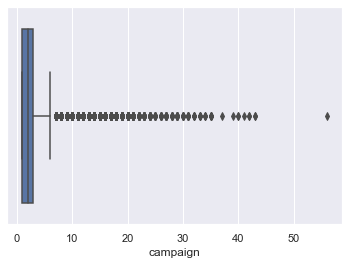

In [22]:
sns.boxplot(x=df_eda['campaign'])

Does prior contact with a customer improve conversions? 

Lets explore *Previous* attribute


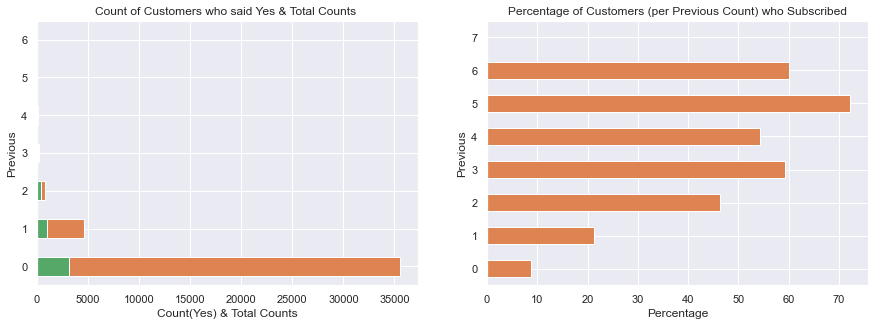

In [23]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["previous"].value_counts().plot(kind='barh', color="C1", ax=axs[0])
df_eda[df_eda["y"]=='yes']["previous"].value_counts().plot(kind='barh', ax = ax, color="C2")
ax = (df_eda[df_eda["y"]=='yes']["previous"].value_counts() * 100 / df_eda["previous"].value_counts() ).plot(kind='barh', color="C1", ax=axs[1])

axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Previous')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Previous')
axs[1].title.set_text('Percentage of Customers (per Previous Count) who Subscribed')

*Conclusion:*

*   Interestingly, if a customer is contacted atleast a couple of times before a campaign begins, chances of the success of the campaign improve by 50% or more. In some cases upto 70%.

Does previous marketting campaigns affect the decision in the next campaign ?

Lets get an insight on *Poutcome*

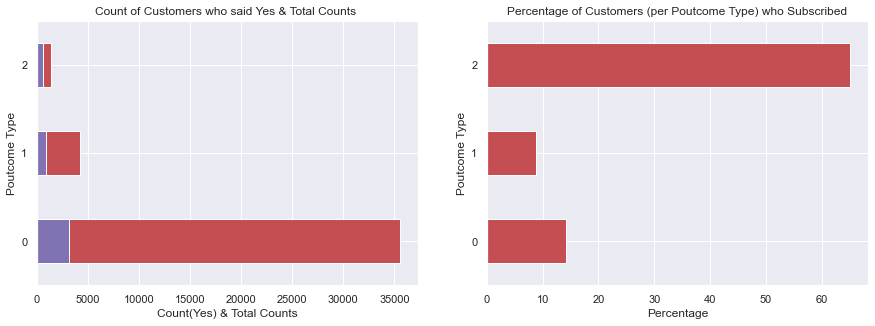

In [24]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["poutcome"].value_counts().plot(kind='barh', color="C3", ax=axs[0])
df_eda[df_eda["y"]=='yes']["poutcome"].value_counts().plot(kind='barh', ax = ax, color="C4")
ax = (df_eda[df_eda["y"]=='yes']["poutcome"].value_counts() * 100 / df_eda["poutcome"].value_counts() ).plot(kind='barh', color="C3", ax=axs[1])

axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Poutcome Type')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Poutcome Type')
axs[1].title.set_text('Percentage of Customers (per Poutcome Type) who Subscribed')

*Conclusion:*

*   If the previous campaign was a success with a customer, there is a 60% chance the current campaign will succeed.

*Pdays*

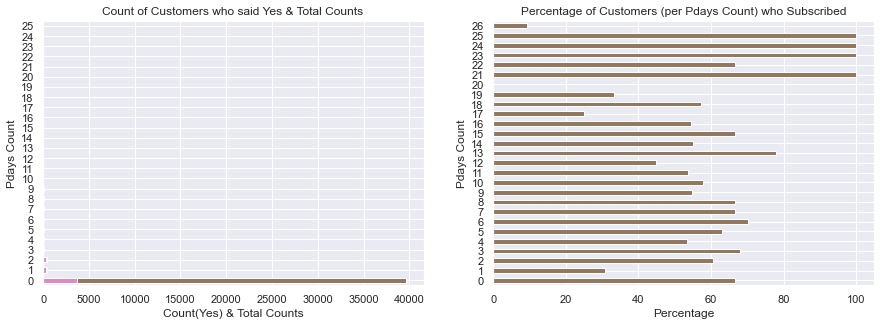

In [25]:
fig, axs = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout(pad=3)

ax = df_eda["pdays"].value_counts().plot(kind='barh', color="C5", ax=axs[0])
df_eda[df_eda["y"]=='yes']["pdays"].value_counts().plot(kind='barh', ax = ax, color="C6")
ax = (df_eda[df_eda["y"]=='yes']["pdays"].value_counts() * 100 / df_eda["pdays"].value_counts() ).plot(kind='barh', color="C5", ax=axs[1])

axs[0].set_xlabel('Count(Yes) & Total Counts')
axs[0].set_ylabel('Pdays Count')
axs[0].title.set_text('Count of Customers who said Yes & Total Counts ')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Pdays Count')
axs[1].title.set_text('Percentage of Customers (per Pdays Count) who Subscribed')

Atleast a single contact improves the changes of the campaign drastically. Look for Pdays=999 ( which means customer was not contacted before)

Lets plot 
*   *emp.var.rate* 
*   *euribor3m*
*   *cons.price.idx*
*   *nr.employed*



Text(0.5, 0.98, 'Percentage of Customers who Subscribed')

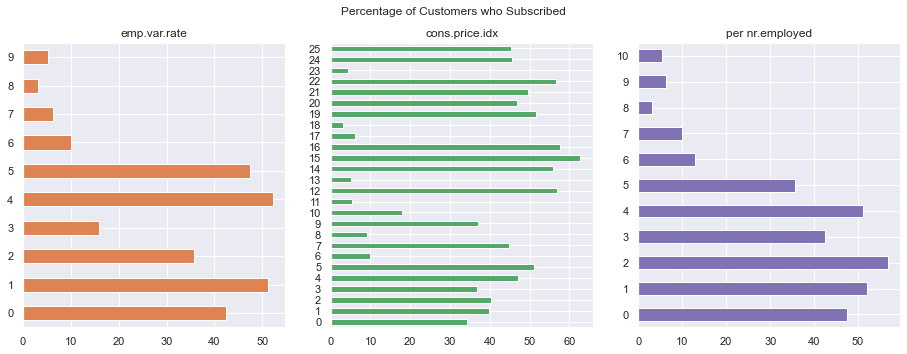

In [26]:
fig, axs = plt.subplots(1,3, figsize=(13,5))
plt.tight_layout()

fig.suptitle("Percentage of Customers who Subscribed", fontsize=12)
fig.subplots_adjust(top=0.88)
ax = (df_eda[df_eda["y"]=='yes']["emp.var.rate"].value_counts() * 100 / df_eda["emp.var.rate"].value_counts() ).plot(kind='barh', color="C1", ax=axs[0])
ax = (df_eda[df_eda["y"]=='yes']["cons.price.idx"].value_counts() * 100 / df_eda["cons.price.idx"].value_counts() ).plot(kind='barh', color="C2", ax=axs[1])
ax = (df_eda[df_eda["y"]=='yes']["nr.employed"].value_counts() * 100 / df_eda["nr.employed"].value_counts() ).plot(kind='barh', color="C4", ax=axs[2])
axs[0].title.set_text('emp.var.rate')
axs[1].title.set_text('cons.price.idx')
axs[2].title.set_text('per nr.employed')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs[2].yaxis.set_major_formatter(FormatStrFormatter('%d'))
fig.suptitle("Percentage of Customers who Subscribed", fontsize=12)

emp.var.rate & cons.price.idx have a certain degree of correlation

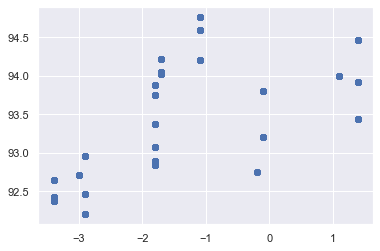

In [27]:
plt.scatter(x=df_eda['emp.var.rate'], y=df_eda['cons.price.idx'], alpha=0.5)

euribor3m & nr.employed too have a correlation

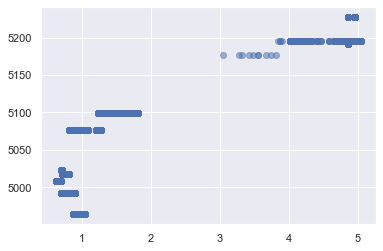

In [28]:
plt.scatter(x=df_eda['euribor3m'], y=df_eda['nr.employed'], alpha=0.5)

Correlation can be further explored with df_cat.corr(). I have checked this and there is minimal feature correlation apart from the above two. 

Lets preprocess the data now.

## DATA PREPROCESSING

We will maintain 2 dataframes, 
*   one for categorical encoded data 
*   and another for one-hot-encoded data



In [29]:
df_enc = df_eda.copy()
df_cat = df_eda.copy()

Setup Categorical dataframe

In [30]:
df_eda.job = pd.Categorical(df_eda.job)
df_cat['job'] = df_eda.job.cat.codes

df_eda.marital = pd.Categorical(df_eda.marital)
df_cat['marital'] = df_eda.marital.cat.codes

df_eda.education = pd.Categorical(df_eda.education)
df_cat['education'] = df_eda.education.cat.codes

df_eda.default = pd.Categorical(df_eda.default)
df_cat['default'] = df_eda.default.cat.codes

df_eda.housing = pd.Categorical(df_eda.housing)
df_cat['housing'] = df_eda.housing.cat.codes

df_eda.loan = pd.Categorical(df_eda.loan)
df_cat['loan'] = df_eda.loan.cat.codes

df_eda.contact = pd.Categorical(df_eda.contact)
df_cat['contact'] = df_eda.contact.cat.codes

df_eda.month = pd.Categorical(df_eda.month)
df_cat['month'] = df_eda.month.cat.codes

df_eda.day_of_week = pd.Categorical(df_eda.day_of_week)
df_cat['day_of_week'] = df_eda.day_of_week.cat.codes

df_eda.poutcome = pd.Categorical(df_eda.poutcome)
df_cat['poutcome'] = df_eda.poutcome.cat.codes


Setup One-hot Encoded dataframe

In [31]:
encoded_jobs = pd.get_dummies(df_eda['job'])
df_enc = pd.concat([df_enc, encoded_jobs], axis=1)
df_enc.drop(['job'], axis=1, errors='ignore',  inplace=True)
df_enc.rename({'unknown': 'unknown_job'}, axis=1, inplace=True)

encoded_marital = pd.get_dummies(df_eda['marital'])
df_enc = pd.concat([df_enc, encoded_marital], axis=1)
df_enc.drop(['marital'], axis=1, errors='ignore',  inplace=True)
df_enc.rename({'unknown': 'unknown_marital'}, axis=1, inplace=True)

encoded_education = pd.get_dummies(df_eda['education'])
df_enc = pd.concat([df_enc, encoded_education], axis=1)
df_enc.drop(['education'], axis=1, errors='ignore',  inplace=True)
df_enc.rename({'unknown': 'unknown_edu'}, axis=1, inplace=True)

encoded_default = pd.get_dummies(df_eda['default'])
df_enc = pd.concat([df_enc, encoded_default], axis=1)
df_enc.drop(['default'], axis=1, errors='ignore',  inplace=True)
df_enc.rename({'unknown': 'unknown_default'}, axis=1, inplace=True)
df_enc.rename({'yes': 'yes_default'}, axis=1, inplace=True)
df_enc.rename({'no': 'no_default'}, axis=1, inplace=True)

encoded_housing = pd.get_dummies(df_eda['housing'])
df_enc = pd.concat([df_enc, encoded_housing], axis=1)
df_enc.drop(['housing'], axis=1, errors='ignore',  inplace=True)
df_enc.rename({'unknown': 'unknown_housing'}, axis=1, inplace=True)
df_enc.rename({'yes': 'yes_housing'}, axis=1, inplace=True)
df_enc.rename({'no': 'no_housing'}, axis=1, inplace=True)

encoded_loan = pd.get_dummies(df_eda['loan'])
df_enc = pd.concat([df_enc, encoded_loan], axis=1)
df_enc.drop(['loan'], axis=1, errors='ignore',  inplace=True)
df_enc.rename({'unknown': 'unknown_loan'}, axis=1, inplace=True)
df_enc.rename({'yes': 'yes_loan'}, axis=1, inplace=True)
df_enc.rename({'no': 'no_loan'}, axis=1, inplace=True)


encoded_contact = pd.get_dummies(df_eda['contact'])
df_enc = pd.concat([df_enc, encoded_contact], axis=1)
df_enc.drop(['contact'], axis=1, errors='ignore',  inplace=True)

encoded_month = pd.get_dummies(df_eda['month'])
df_enc = pd.concat([df_enc, encoded_month], axis=1)
df_enc.drop(['month'], axis=1, errors='ignore',  inplace=True)

encoded_day_of_week = pd.get_dummies(df_eda['day_of_week'])
df_enc = pd.concat([df_enc, encoded_day_of_week], axis=1)
df_enc.drop(['day_of_week'], axis=1, errors='ignore',  inplace=True)

encoded_poutcome = pd.get_dummies(df_eda['poutcome'])
df_enc = pd.concat([df_enc, encoded_poutcome], axis=1)
df_enc.drop(['poutcome'], axis=1, errors='ignore',  inplace=True)

df_eda.y = pd.Categorical(df_eda.y)
df_cat['y'] = df_eda.y.cat.codes
df_enc['y'] = df_eda.y.cat.codes

How do the features match up for correlation? 

<AxesSubplot:>

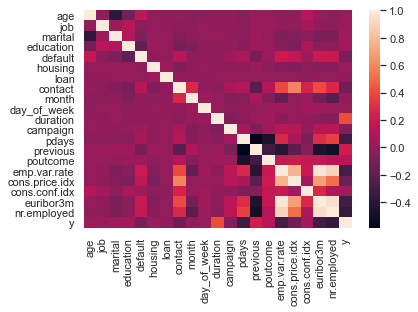

In [32]:
corr = df_cat.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [33]:
y_cat = df_cat['y'].copy()
y_enc = df_enc['y'].copy()

df_cat.drop(['y'], axis=1, errors='ignore', inplace=True)
df_enc.drop(['y'], axis=1, errors='ignore', inplace=True)

In [38]:
df_cat
df_enc

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,oct,sep,fri,mon,thu,tue,wed,failure,nonexistent,success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,0,0,0,1,0
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,0,0,0,1,0
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,0,0,0,1,0
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,0,0,0,1,0


Split data into train and test.

In [34]:
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(df_cat, y_cat, stratify=y_cat, test_size=0.25)
X_enc_train, X_enc_test, y_enc_train, y_enc_test = train_test_split(df_enc, y_enc, stratify=y_enc, test_size=0.25)

**SMOTE**

Since the data is imbalanced, lets balance it by generating some synthetic data for the minority class. This improves ML Models' scores and performance. 

The F1 scores for all the models improved by about 2% by introducing SMOTE.

In [35]:
X_enc_train_SMT = X_enc_train.copy()
y_enc_train_SMT = y_enc_train.copy()

smote_nc = SMOTENC(categorical_features=[10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62], random_state=0)
X_enc_train_SMT2, y_enc_train_SMT2 = smote_nc.fit_resample(X_enc_train_SMT, y_enc_train_SMT)

X_enc_train = pd.DataFrame(X_enc_train_SMT2, columns=df_enc.columns)
y_enc_train = y_enc_train_SMT2

In [36]:
X_cat_train_SMT = X_cat_train.copy()
y_cat_train_SMT = y_cat_train.copy()

smote_nc = SMOTENC(categorical_features=[2, 3, 4, 5, 6, 7, 8, 9], random_state=0)
X_cat_train_SMT2, y_cat_train_SMT2 = smote_nc.fit_resample(X_cat_train_SMT, y_cat_train_SMT)

X_cat_train = pd.DataFrame(X_cat_train_SMT2, columns=df_cat.columns)
y_cat_train = y_cat_train_SMT2

**Standardization**

Data needs to normaliszed to make it Machine Learn'able. 

*   We will use MinMaxScaler for all the models except Logistic Regression. All of the remaining models perform well with MinMaxScaler
*   For Logistic Regression, StandardScaler is appropriate.



In [39]:
scaler = MinMaxScaler()
X_cat_train[['age', 'duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']] = scaler.fit_transform(X_cat_train[['age', 'duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']])
X_cat_test[['age', 'duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']] = scaler.fit_transform(X_cat_test[['age', 'duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']])

pd.options.mode.chained_assignment = None
X_enc_std_train = X_enc_train.copy(deep=True)
X_enc_std_test = X_enc_test.copy(deep=True)

X_enc_train[['age', 'duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']] = scaler.fit_transform(X_enc_train[['age', 'duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']])
X_enc_test[['age', 'duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']] = scaler.fit_transform(X_enc_test[['age', 'duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']])

scaler2 = StandardScaler()
pd.options.mode.chained_assignment = None
X_enc_std_train[['age', 'duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']] = scaler2.fit_transform(X_enc_std_train[['age', 'duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']])
X_enc_std_test[['age', 'duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']] = scaler2.fit_transform(X_enc_std_test[['age', 'duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']])


## MODEL EVALUATION


---






**Hyperparameter Tuning:** To get the best hyperparameters, we will use GridsearchCV for all the models 

---
**Improve Scores** - To improve the F1 Scores / ROC_AUC scores, SMOTE is used to increase the values of minority class for training. This improved the score for each of the models by around 2%

---
**ROC-AUC / PRAUC Curves** indicate which model performs better than the others.

---
**Models** - For classification, following models have been considered. 

*   Gradient Boosted Trees
*   XGBosst
*   Light GBM
*   Logistic Regression
*   Support Vector Machines
*   Naive Bayes (Gaussian NB)
*   KNN
*   Neural Networks (Keras/Tensorflow)
---
**Evaluation Metrics:** The dataset is imbalanced, there are more rows for Label y=NO than there are for y=YES, so accuracy will not be the appropriate pointer for a successful model. F1 score, ROC_AUC, Kappa & PR AUC are the appropriate metrics for a skewed dataset.

---


**Round 1 : Grandient Boosted Trees**


Pull up the best hyperparameters for GBTs

In [40]:
p_test3 = {'learning_rate':[1, 0.50,0.25], 'n_estimators':[70,100], 'max_depth':[3,8,12], "min_samples_split": np.linspace(0.1, 0.5, 2, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 1, 12)}


tuning = GridSearchCV(estimator =GradientBoostingClassifier(subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='f1',n_jobs=4,iid=False, cv=5)
tuning.fit(X_cat_train, y_cat_train)
print(tuning.best_params_)
print(tuning.score(X_cat_train, y_cat_train))
print(tuning.best_score_)

KeyboardInterrupt: 

In [ ]:
gb_clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_features=5, max_depth=8, random_state=0) #0.548 0.72

gb_clf2.fit(X_cat_train, y_cat_train)
predictions = gb_clf2.predict(X_cat_test)

print("Confusion Matrix:")
print(confusion_matrix(y_cat_test, predictions))
print(" ")
print("Classification Report")
print(classification_report(y_cat_test, predictions))
print(" ")
print("Kappa- ", cohen_kappa_score(y_cat_test, predictions))
print("F1- ", f1_score(y_cat_test, predictions))
print("ROC_AUC_score- ", roc_auc_score(y_cat_test, predictions))
print("PR AUC- ", average_precision_score(y_cat_test, predictions))

print(" ")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
fig.tight_layout()

fpr, tpr, threshold = metrics.roc_curve(y_cat_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
ax1.set_title('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_cat_test, predictions)
ax2.set_title('Precision-Recall AUC Curve')
ax2.plot(lr_recall, lr_precision, marker='.')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.show()

**Round 2 :  XGBoost**


use categorical dataframe

In [ ]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='f1', n_jobs=4, cv=skf.split(X_cat_train, y_cat_train), verbose=3, random_state=1001 )

random_search.fit(X_cat_train, y_cat_train)


In [ ]:
print(random_search.best_params_)
print(random_search.score(X_cat_train, y_cat_train))
print(random_search.best_score_)

In [ ]:
xgb_clf = XGBClassifier(subsample=0.8, min_child_weight=1, max_depth=4, gamma=1, colsample_bytree=1.0) #0.53 0.70

xgb_clf.fit(X_cat_train, y_cat_train)

In [ ]:
predictions = xgb_clf.predict(X_cat_test)

print("Confusion Matrix:")
print(confusion_matrix(y_cat_test, predictions))

print("Classification Report")
print(classification_report(y_cat_test, predictions))

print("Kappa- ", cohen_kappa_score(y_cat_test, predictions))
print("F1- ", f1_score(y_cat_test, predictions))
print("ROC_AUC_score- ", roc_auc_score(y_cat_test, predictions))
print("PR AUC- ", average_precision_score(y_cat_test, predictions))

print(" ")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
fig.tight_layout()

fpr, tpr, threshold = metrics.roc_curve(y_cat_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
ax1.set_title('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_cat_test, predictions)
ax2.set_title('Precision-Recall AUC Curve')
ax2.plot(lr_recall, lr_precision, marker='.')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.show()

In [ ]:
score = xgb_clf.score(X_cat_test, y_cat_test)
print(score)

**Round 3 : Logistic Regression**

use one hot encoded dataframe

In [ ]:
logreg=LogisticRegression()
grid={"C":np.logspace(-3,3,7), "penalty":["l2"], 'max_iter':[10000]}

logreg_cv=GridSearchCV(logreg,grid,scoring='f1', cv=10)
logreg_cv.fit(X_enc_std_train,y_enc_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

print(logreg_cv.best_params_)
print(logreg_cv.score(X_enc_std_train,y_enc_train))
print(logreg_cv.best_score_)


In [ ]:
logreg2=LogisticRegression(C=100,penalty="l2", max_iter=10000) #0.60 0.77 , solver='liblinear'
logreg2.fit(X_enc_train,y_enc_train)
print("score",logreg2.score(X_enc_test,y_enc_test))

In [ ]:
predictions = logreg2.predict(X_enc_test)

print("Confusion Matrix:")
print(confusion_matrix(y_enc_test, predictions))

print("Classification Report")
print(classification_report(y_enc_test, predictions))

print("Kappa- ", cohen_kappa_score(y_enc_test, predictions))
print("F1- ", f1_score(y_enc_test, predictions))
print("ROC_AUC_score- ", roc_auc_score(y_enc_test, predictions))
print("PR AUC- ", average_precision_score(y_enc_test, predictions))


print(" ")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
fig.tight_layout()

fpr, tpr, threshold = metrics.roc_curve(y_enc_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
ax1.set_title('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_enc_test, predictions)
ax2.set_title('Precision-Recall AUC Curve')
ax2.plot(lr_recall, lr_precision, marker='.')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.show()

**Round 4 : Light GBM**

In [ ]:
lgbm=LGBMClassifier()
lgbm.fit(X_cat_train,y_cat_train)
print("score",lgbm.score(X_cat_test,y_cat_test))

In [ ]:
predictions = lgbm.predict(X_cat_test)

print("Confusion Matrix:")
print(confusion_matrix(y_cat_test, predictions))

print("Classification Report")
print(classification_report(y_cat_test, predictions))

print("Kappa- ", cohen_kappa_score(y_cat_test, predictions))
print("F1- ", f1_score(y_cat_test, predictions))
print("ROC_AUC_score- ", roc_auc_score(y_cat_test, predictions))
print("PR AUC- ", average_precision_score(y_cat_test, predictions))


print(" ")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
fig.tight_layout()

fpr, tpr, threshold = metrics.roc_curve(y_cat_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
ax1.set_title('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_cat_test, predictions)
ax2.set_title('Precision-Recall AUC Curve')
ax2.plot(lr_recall, lr_precision, marker='.')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.show()

**Round 5 : Naive Bayes**

uses one hot encoded data

In [ ]:
skf = StratifiedKFold(n_splits=10)
params = {}

nb = GaussianNB() 
gs = GridSearchCV(nb, cv=skf, param_grid=params, scoring='f1', return_train_score=True)
gs.fit(X_enc_train, y_enc_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",gs.best_score_)

print(gs.best_params_)
print(gs.score(X_enc_train,y_enc_train))
print(gs.best_score_)

In [ ]:
gnb = GaussianNB() 

gnb.fit(X_enc_train, y_enc_train)

predictions = gnb.predict(X_enc_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_enc_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_enc_test, predictions))

print("Classification Report")
print(classification_report(y_enc_test, predictions))

print("Kappa- ", cohen_kappa_score(y_enc_test, predictions))
print("F1- ", f1_score(y_enc_test, predictions))
print("ROC_AUC_score- ", roc_auc_score(y_enc_test, predictions))
print("PR AUC- ", average_precision_score(y_enc_test, predictions))


print(" ")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
fig.tight_layout()

fpr, tpr, threshold = metrics.roc_curve(y_enc_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
ax1.set_title('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_enc_test, predictions)
ax2.set_title('Precision-Recall AUC Curve')
ax2.plot(lr_recall, lr_precision, marker='.')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.show()

**Round 6 : Support Vector Machines**

accepts categorical data


In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.1],
                     'C': [1]},
                    {'kernel': ['linear'], 'C': [1]}]

clf = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='precision')
clf.fit(X_cat_train, y_cat_train)

print('The best model is: ', clf.best_params_)
print('Mean cross-validated score (precision) of', clf.best_score_)

In [ ]:
clf = svm.SVC(kernel='linear') 

clf.fit(X_cat_train, y_cat_train)

predictions = clf.predict(X_cat_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_cat_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_cat_test, predictions))

print("Classification Report")
print(classification_report(y_cat_test, predictions))

print("Kappa- ", cohen_kappa_score(y_cat_test, predictions))
print("F1- ", f1_score(y_cat_test, predictions))
print("ROC_AUC_score- ", roc_auc_score(y_cat_test, predictions))
print("PR AUC- ", average_precision_score(y_cat_test, predictions))


print(" ")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
fig.tight_layout()

fpr, tpr, threshold = metrics.roc_curve(y_cat_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
ax1.set_title('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_cat_test, predictions)
ax2.set_title('Precision-Recall AUC Curve')
ax2.plot(lr_recall, lr_precision, marker='.')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.show()

**Round 7 : KNN**

In [ ]:
neighbors = np.arange(1,19)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(X_cat_train, y_cat_train)
    
    train_accuracy[i] = knn.score(X_cat_train, y_cat_train)
    
    test_accuracy[i] = knn.score(X_cat_test, y_cat_test) 

In [ ]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_cat_train, y_cat_train)
predictions = knn.predict(X_cat_test)

print("Accuracy:",metrics.accuracy_score(y_cat_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_cat_test, predictions))

print("Classification Report")
print(classification_report(y_cat_test, predictions))

print("Kappa- ", cohen_kappa_score(y_cat_test, predictions))
print("F1- ", f1_score(y_cat_test, predictions))
print("ROC_AUC_score- ", roc_auc_score(y_cat_test, predictions))
print("PR AUC- ", average_precision_score(y_cat_test, predictions))

print(" ")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
fig.tight_layout()

fpr, tpr, threshold = metrics.roc_curve(y_cat_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
ax1.set_title('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_cat_test, predictions)
ax2.set_title('Precision-Recall AUC Curve')
ax2.plot(lr_recall, lr_precision, marker='.')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.show()

**Round 8 : Deep Learning**

In [ ]:
def create_model():
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(63,)),
    tf.keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [100, 150]
epochs = [10]
param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_enc_train, y_enc_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(63,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(), #from_logits=True
              metrics=['AUC'])

model.summary()

history = model.fit(X_enc_train, y_enc_train, epochs=10)

test_loss, test_acc = model.evaluate(X_enc_test, y_enc_test, verbose=0)
predictions = model.predict(X_enc_test)

predictions[predictions>0.5] = 1
predictions[predictions<=0.5] = 0

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_enc_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_enc_test, predictions))

print("Classification Report")
print(classification_report(y_enc_test, predictions))

print("Kappa- ", cohen_kappa_score(y_enc_test, predictions))
print("F1- ", f1_score(y_enc_test, predictions))
print("ROC_AUC_score- ", roc_auc_score(y_enc_test, predictions))
print("PR AUC- ", average_precision_score(y_enc_test, predictions))

print(" ")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
fig.tight_layout()

fpr, tpr, threshold = metrics.roc_curve(y_enc_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
ax1.set_title('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_enc_test, predictions)
ax2.set_title('Precision-Recall AUC Curve')
ax2.plot(lr_recall, lr_precision, marker='.')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.show()

## MODEL PERFORMANCE REPORT

| ML MODEL  | F1 SCORE  | ROC AUC  | KAPPA  | PR AUC  |
|---|---|---|---|---|
| Grandient Boosted Trees  | 0.57  | 0.78  | 0.51  | 0.37  |
| XGBoost  | 0.61  | 0.83  | 0.54  | 0.41  |
| Logistic Regression  | 0.59  | 0.76  | 0.54  | 0.40  |
| Light GBM  | 0.62  | 0.85  | 0.56  | 0.43  |
| Naive Bayes (GaussianNB)  | 0.32  | 0.66  | 0.19  | 0.17  |
| Support Vector Machines  | 0.54  | 0.85  | 0.45  | 0.35  |
| KNN  | 0.39  | 0.69  | 0.28  | 0.21  |
| Neural Networks  | 0.58  | 0.77  | 0.52  | 0.38  |


## CONCLUSIONS


---

**Important Conclusions** - 
*   Interestingly, if a customer is contacted atleast a couple of times before a campaign begins, chances of the success of the campaign improve by 50% or more. In some cases upto 70%.
*   Customers above the age of 73 have a 50% chance of saying YES.
*   If the previous campaign was a success with a customer, there is a 60% chance the current campaign will succeed.

---

Here is the **consolidated list** of other conclusions derived from the analysis done earlier.

*   Any customer above the age of 60 has atleast a 40% chance of subscribing for the Bank Term Deposit.
*   Students and Retired customers have a good chance(> 25%) of creating a Fixed Deposit. 
*   Surprisingly, the Illiterate category has a higher chance(> 20%) of opting for the Term Deposit.
*   Mar, Sep, Dec & Oct where great months for the campaign with a 40% or more probability of customers accepting the marketting offer. It generally seems like the last month of each quarter is a fruitful time for campaigning.
*   Increasing the number of calls to a customer only reduces the chances of him accepting the product. 

---

**Best Perfroming Models** - 
*   Light GBM has the top scores for all the metrics and outperforms XGBoost as expected.
*   Its closely followed by XGBoost and Neural Networks. I didnt tune the Neural Network model for lack of more time. This has scope to be tuned and improved.

---
<h3><center>
Hope you liked the notebook. If you did, then give it a vote.
</center></h3>


---